In [1]:
import pandas as pd
import numpy as np
import random
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/H2GTRM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# feature importance 
def vis_feature_importances_(est, X_train):
    ftr_importances_values = est.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    plt.figure(figsize=(10,4))
    plt.title('Feature importances Top 20')
    sns.barplot(x=ftr_top20 , y = ftr_top20.index)
    plt.show()

## Data Load

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# train = pd.read_csv('/content/drive/MyDrive/work/input/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/work/input/test.csv')
# building_info = pd.read_csv('/content/drive/MyDrive/work/input/building_info.csv')
# submission = pd.read_csv('/content/drive/MyDrive/work/input/sample_submission.csv')
# train.shape, test.shape, building_info.shape, submission.shape

train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
building_info = pd.read_csv('input/building_info.csv')
submission = pd.read_csv('input/sample_submission.csv')
train.shape, test.shape, building_info.shape, submission.shape

((204000, 10), (16800, 7), (100, 7), (16800, 2))

## Train Data Pre-Processing

In [4]:
# 빌딩 데이터 정리
## null 처리
building_info['태양광용량(kW)'] = building_info['태양광용량(kW)'].str.replace('-','0').astype(float)
building_info['ESS저장용량(kWh)'] = building_info['ESS저장용량(kWh)'].str.replace('-','0').astype(float)
building_info['PCS용량(kW)'] = building_info['PCS용량(kW)'].str.replace('-','0').astype(float)

In [5]:
# 정리된 빌딩과 merge
train = train.merge(building_info, on='건물번호')
test = test.merge(building_info, on='건물번호')

In [6]:
#시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
train['month'] = train['일시'].apply(lambda x : int(x[4:6]))
train['day'] = train['일시'].apply(lambda x : int(x[6:8]))
train['time'] = train['일시'].apply(lambda x : int(x[9:11]))

test['month'] = test['일시'].apply(lambda x : int(x[4:6]))
test['day'] = test['일시'].apply(lambda x : int(x[6:8]))
test['time'] = test['일시'].apply(lambda x : int(x[9:11]))

In [7]:
# 요일
train['weekday'] =  pd.to_datetime(train['일시'].str[:8]).dt.weekday
test['weekday'] =  pd.to_datetime(test['일시'].str[:8]).dt.weekday

In [8]:
target_encoding = train.groupby(['건물유형']).agg({'전력소비량(kWh)':['min', 'mean','max']}).reset_index()
target_encoding.columns = ['건물유형', 'khw_min', 'khw_mean', 'khw_max']
train = train.merge(target_encoding, on=['건물유형'], how='left')
test = test.merge(target_encoding, on=['건물유형'], how='left')

In [9]:
train['냉방비율'] = ((train['냉방면적(m2)'] / train['연면적(m2)'])*100 ).astype(int)
test['냉방비율'] = ((test['냉방면적(m2)'] / test['연면적(m2)'])*100 ).astype(int)

train = train.drop(columns=['연면적(m2)','냉방면적(m2)'])
test = test.drop(columns=['연면적(m2)','냉방면적(m2)'])

In [10]:
#결측값을 0으로 채웁니다
train = train.fillna(0)
test = test.fillna(0)

In [11]:
train_x = train.drop(columns=['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'])
train_y = train['전력소비량(kWh)']

test_x = test.drop(columns=['num_date_time', '일시'])

In [12]:
#결측값을 0으로 채웁니다
train_x = train_x.fillna(0)
train_y = train_y.fillna(0)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_x , train_y ,test_size=0.2, shuffle=True, random_state=42, stratify=train_x['건물번호'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(163200, 17) (40800, 17) (163200,) (40800,)


## Regression Model Fit

,건물번호,score
0,1.0,0.052022


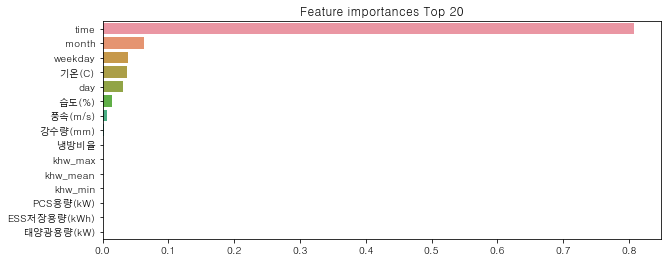

,건물번호,score
0,2.0,0.06419


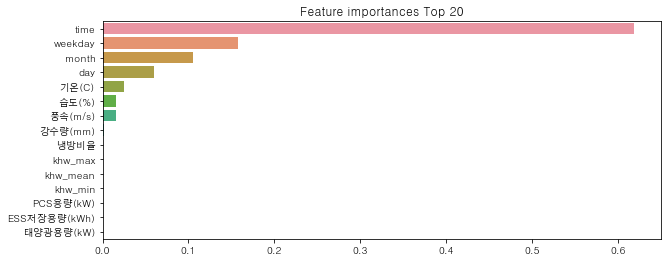

,건물번호,score
0,3.0,0.086363


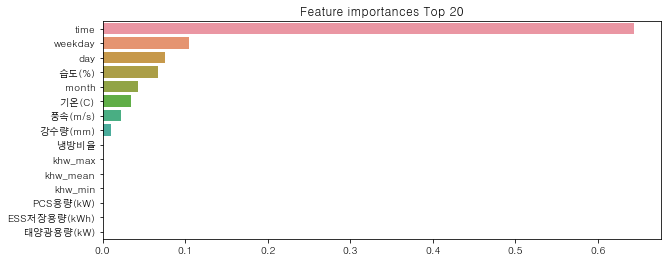

,건물번호,score
0,4.0,0.036504


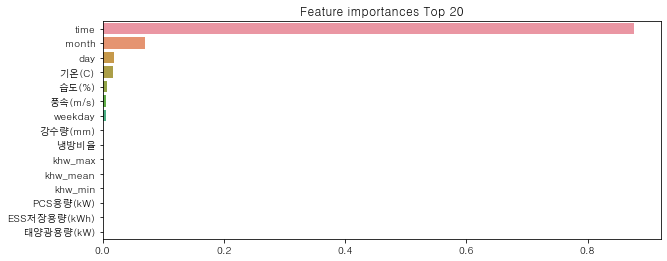

,건물번호,score
0,5.0,0.057013


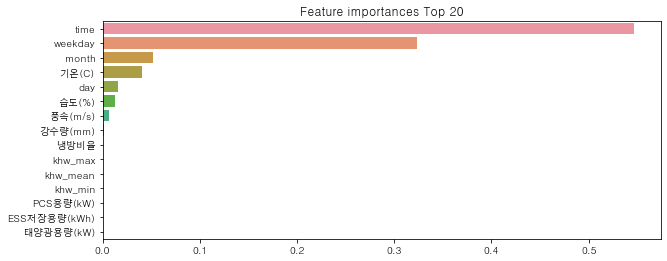

,건물번호,score
0,6.0,0.033968


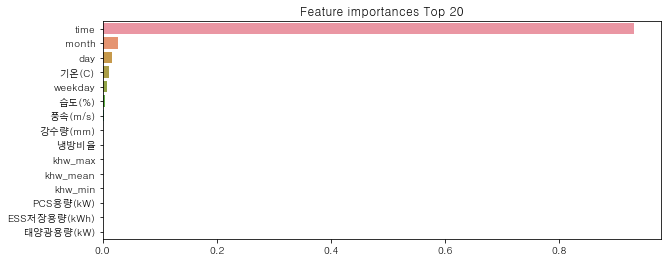

,건물번호,score
0,7.0,0.061991


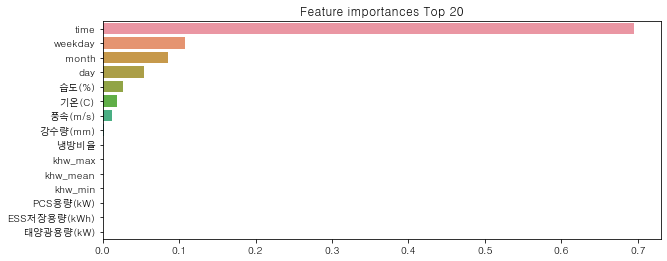

,건물번호,score
0,8.0,0.041882


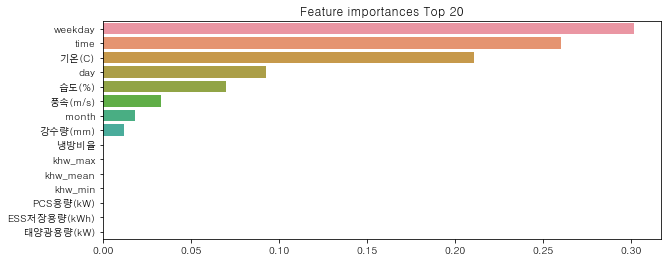

,건물번호,score
0,9.0,0.033994


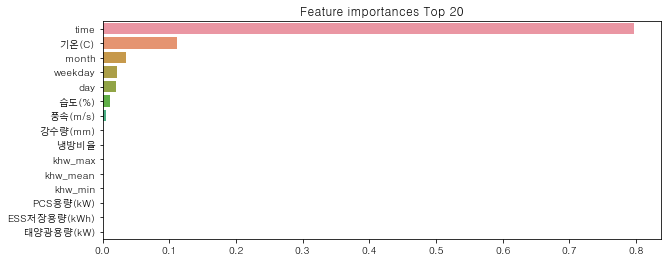

,건물번호,score
0,10.0,0.030918


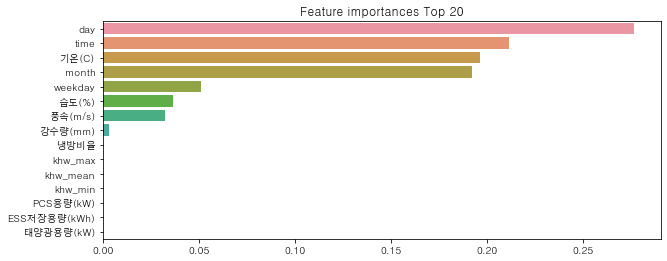

,건물번호,score
0,11.0,0.029866


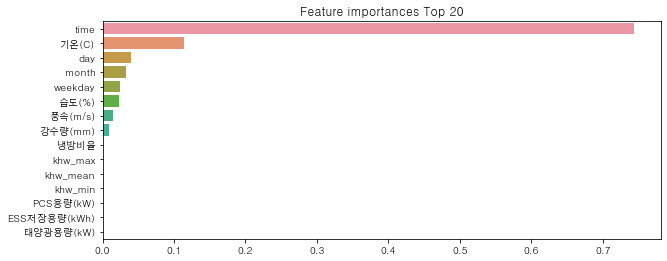

,건물번호,score
0,12.0,0.03098


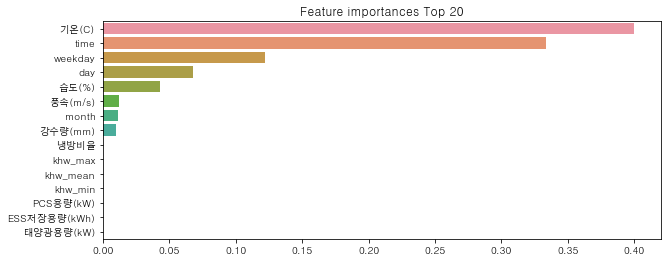

,건물번호,score
0,13.0,0.044957


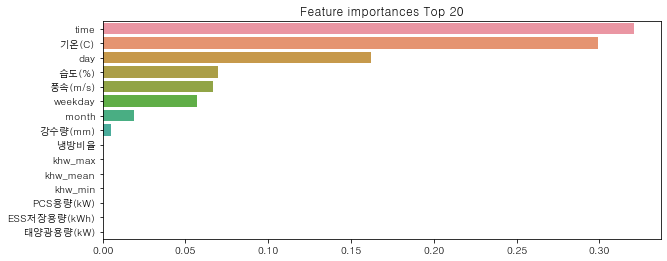

,건물번호,score
0,14.0,0.118087


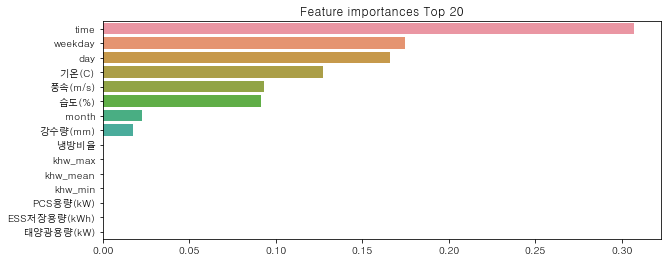

,건물번호,score
0,15.0,0.023972


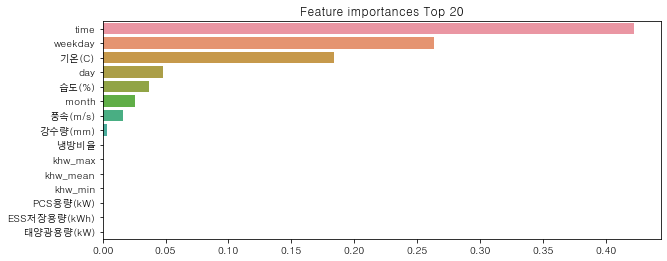

,건물번호,score
0,16.0,0.037632


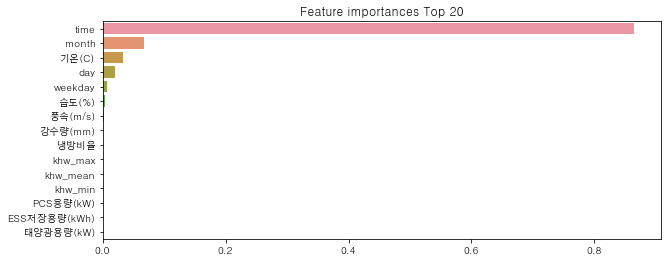

,건물번호,score
0,17.0,0.05684


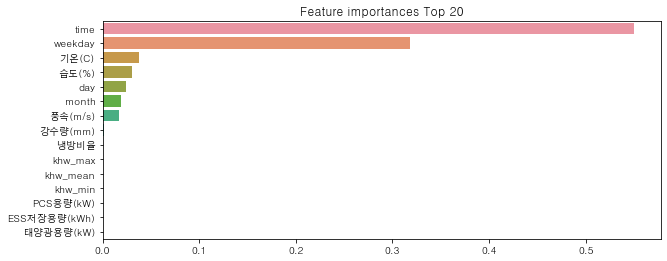

,건물번호,score
0,18.0,0.045079


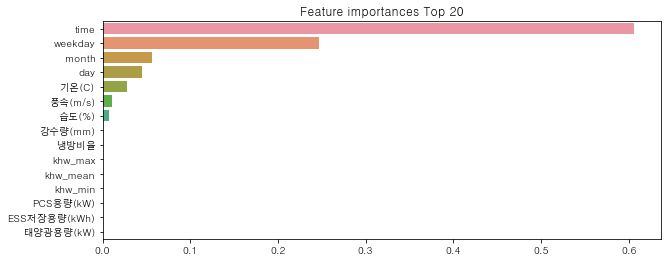

,건물번호,score
0,19.0,0.036893


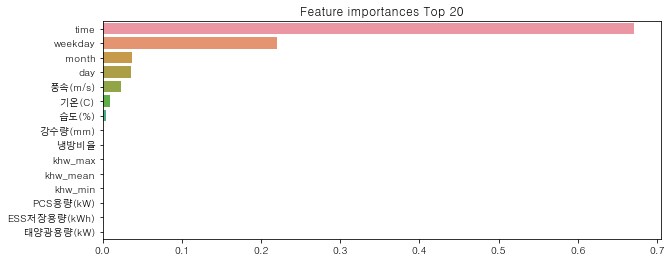

,건물번호,score
0,20.0,0.04973


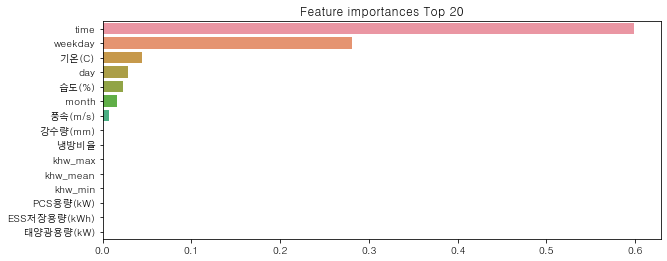

,건물번호,score
0,21.0,0.042087


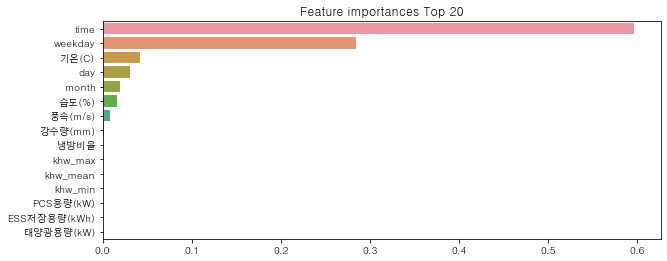

,건물번호,score
0,22.0,0.032892


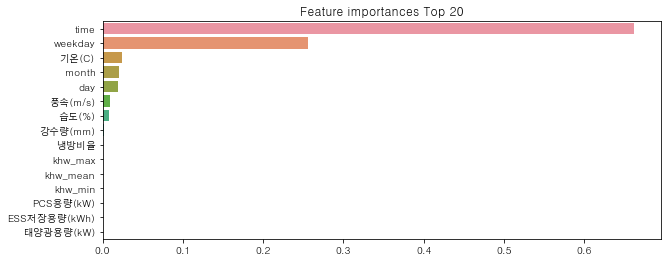

,건물번호,score
0,23.0,0.014309


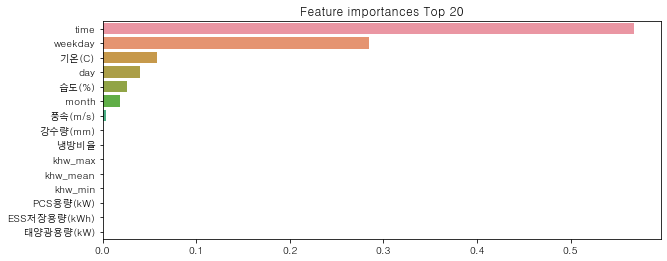

,건물번호,score
0,24.0,0.028968


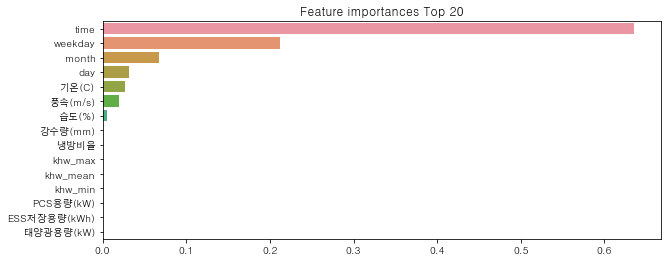

,건물번호,score
0,25.0,0.030957


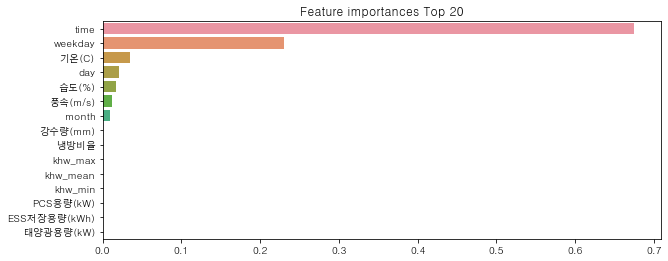

,건물번호,score
0,26.0,0.024977


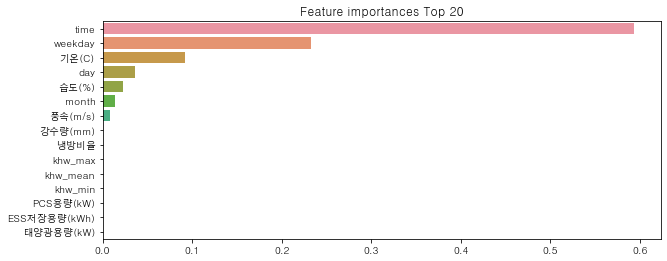

,건물번호,score
0,27.0,0.016486


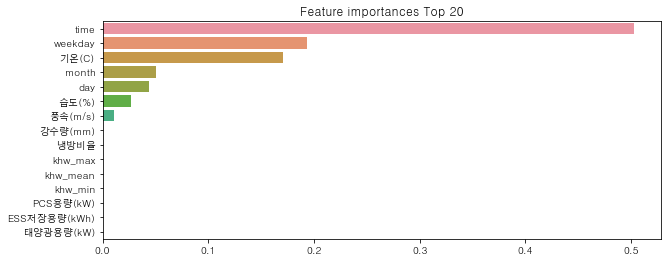

,건물번호,score
0,28.0,0.046811


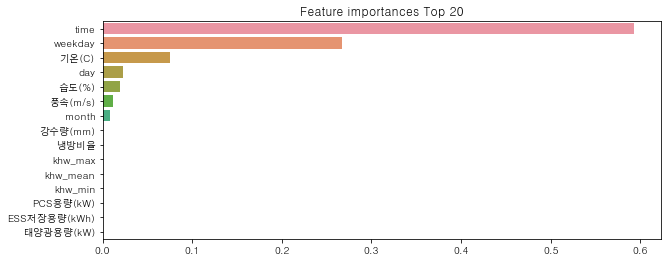

,건물번호,score
0,29.0,0.0323


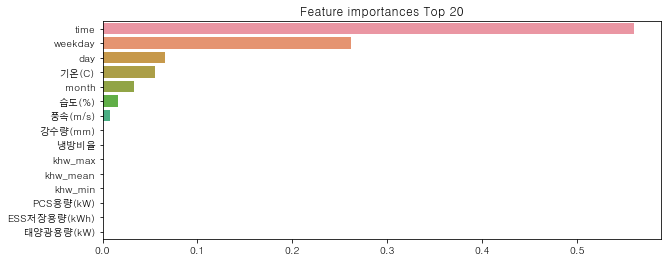

,건물번호,score
0,30.0,0.065007


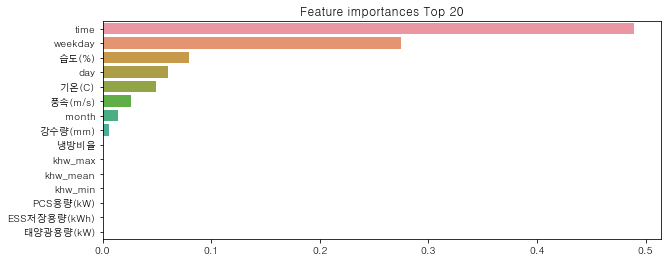

,건물번호,score
0,31.0,0.037473


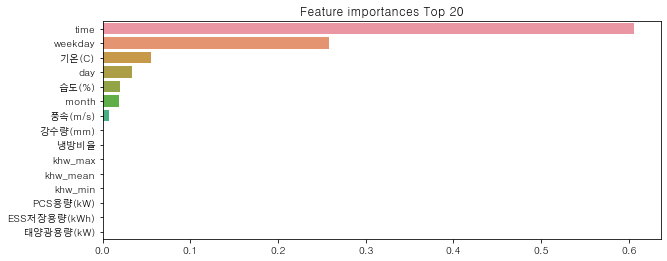

,건물번호,score
0,32.0,0.002798


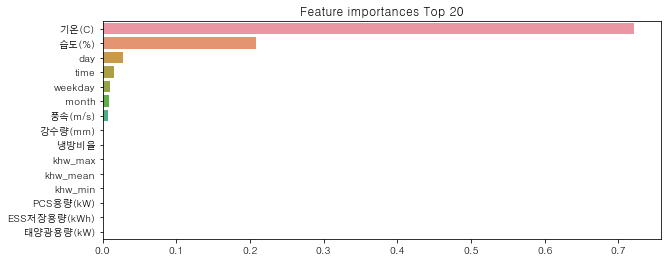

,건물번호,score
0,33.0,0.002747


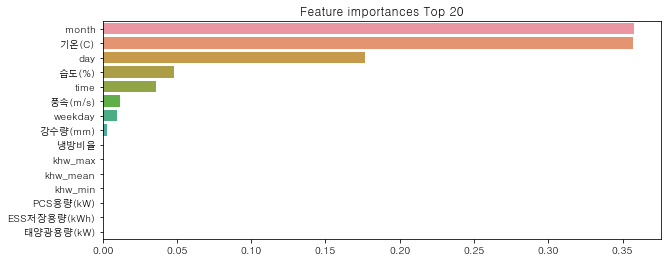

,건물번호,score
0,34.0,0.005441


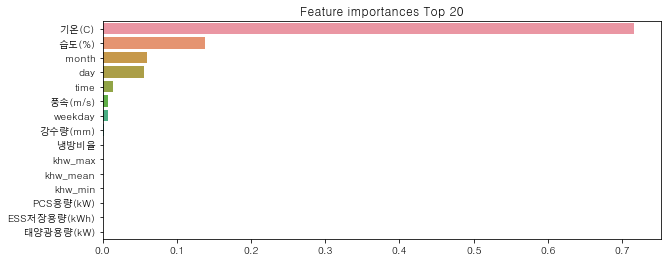

,건물번호,score
0,35.0,0.003394


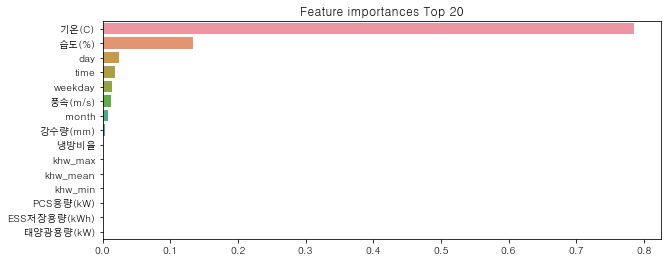

,건물번호,score
0,36.0,0.004469


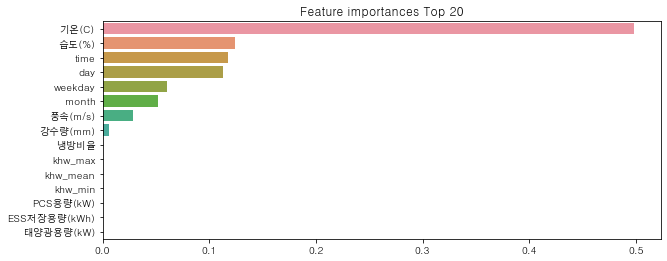

,건물번호,score
0,37.0,0.035805


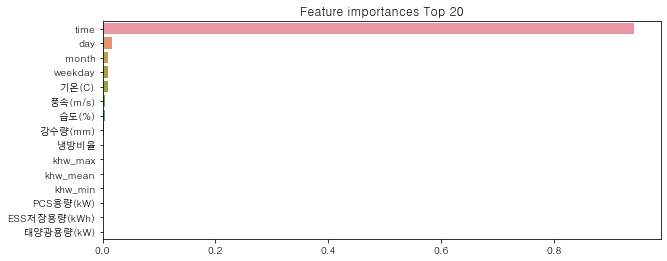

,건물번호,score
0,38.0,0.062456


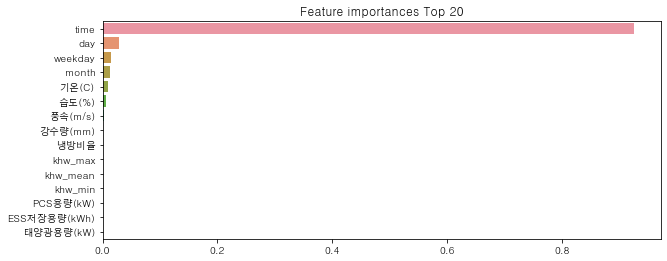

,건물번호,score
0,39.0,0.040705


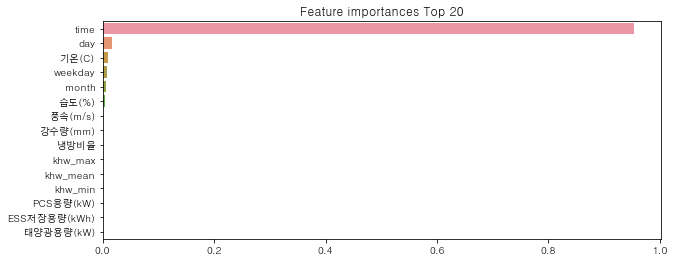

,건물번호,score
0,40.0,0.094951


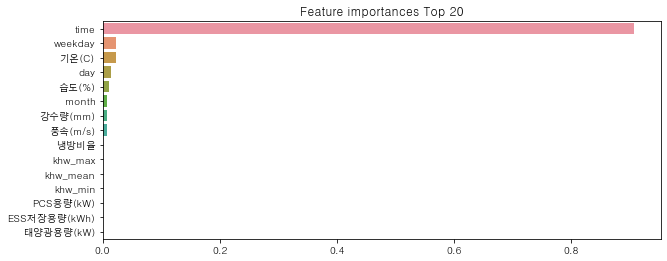

,건물번호,score
0,41.0,0.052371


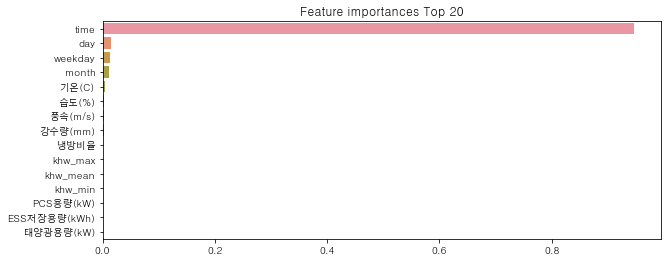

,건물번호,score
0,42.0,0.045146


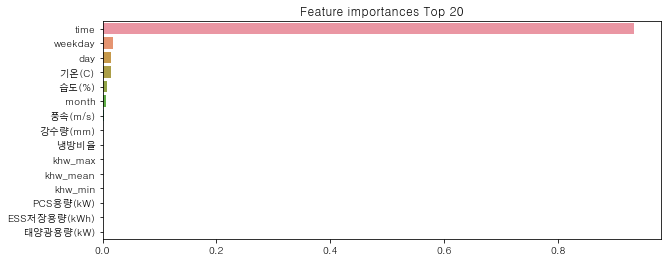

,건물번호,score
0,43.0,0.046316


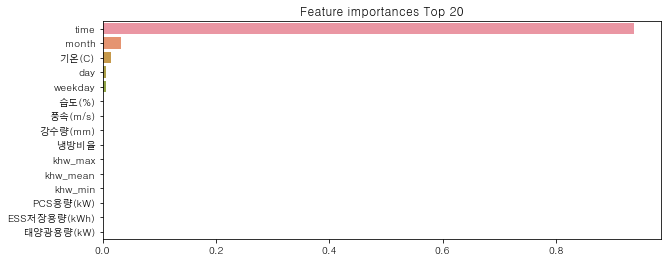

,건물번호,score
0,44.0,0.027171


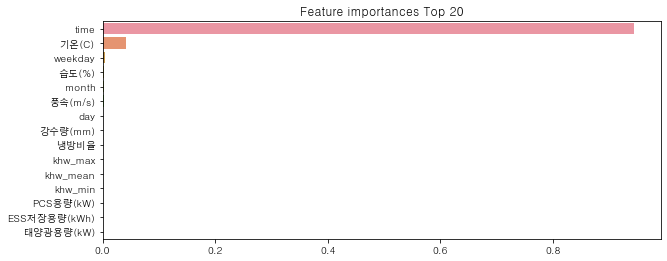

,건물번호,score
0,45.0,0.020812


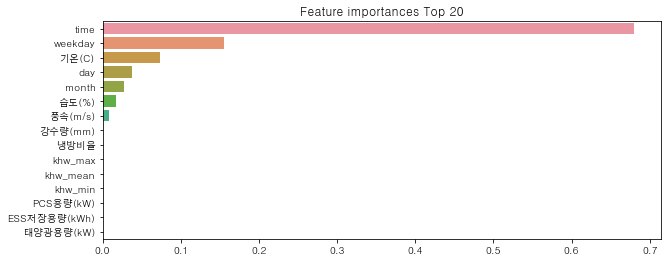

,건물번호,score
0,46.0,0.035691


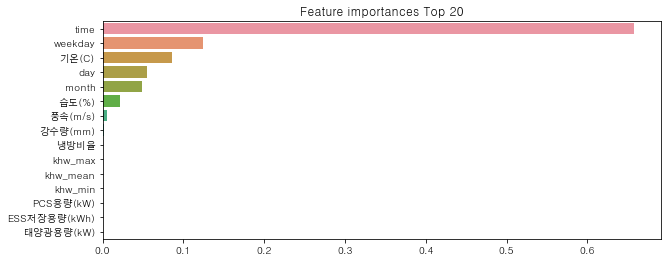

,건물번호,score
0,47.0,0.02417


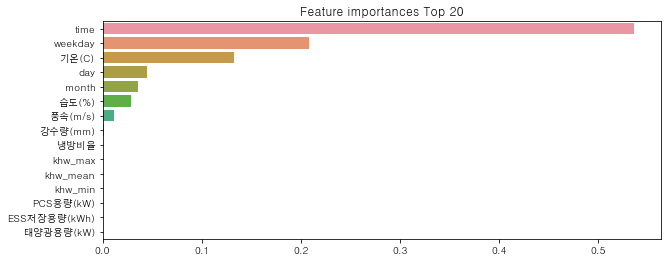

,건물번호,score
0,48.0,0.025357


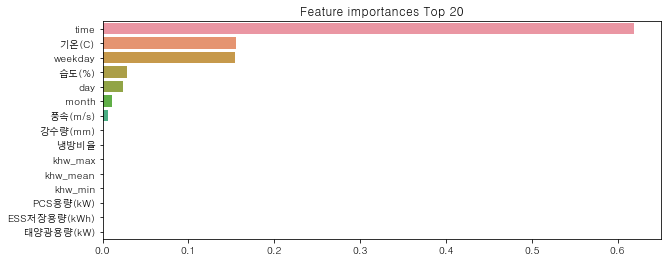

,건물번호,score
0,49.0,0.020828


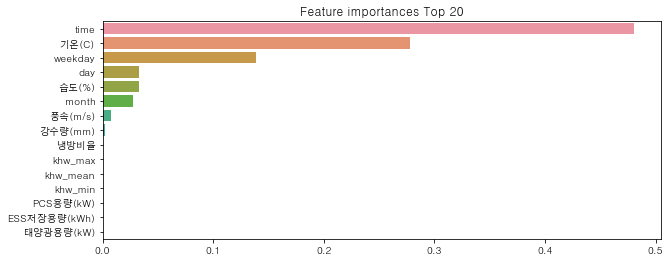

,건물번호,score
0,50.0,0.022506


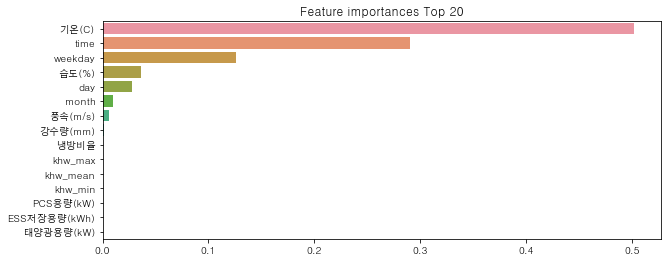

,건물번호,score
0,51.0,0.030795


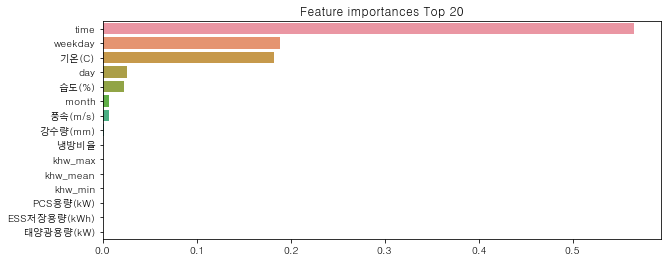

,건물번호,score
0,52.0,0.030945


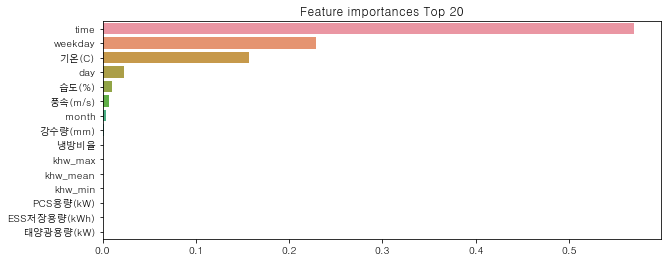

,건물번호,score
0,53.0,0.074908


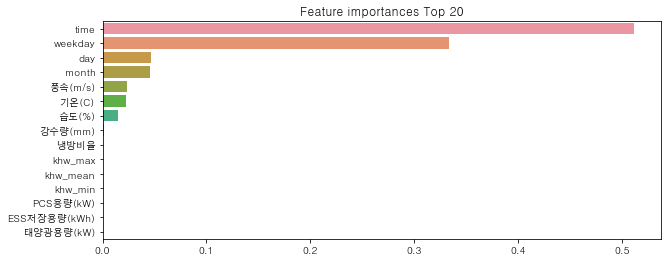

,건물번호,score
0,54.0,0.076068


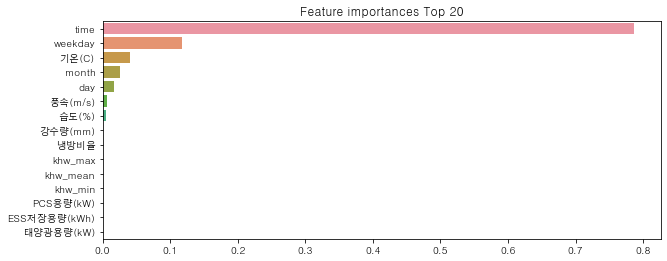

,건물번호,score
0,55.0,0.011458


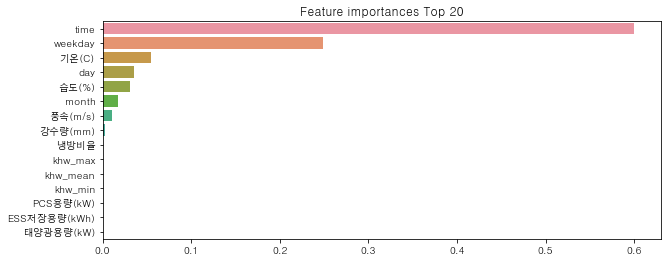

,건물번호,score
0,56.0,0.006328


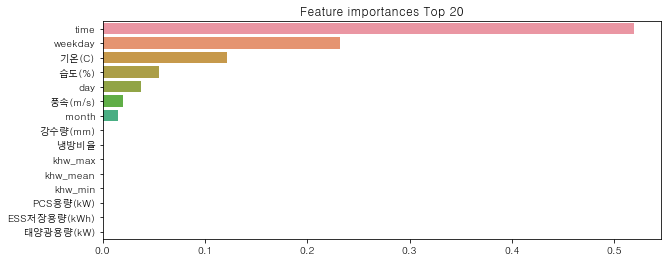

,건물번호,score
0,57.0,0.045747


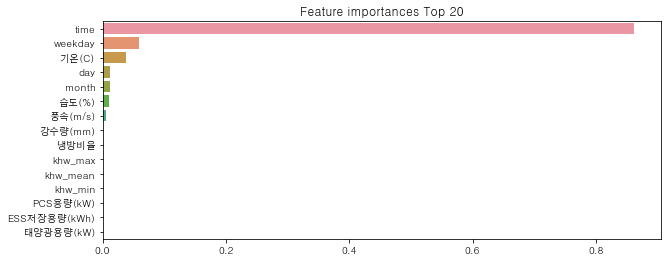

,건물번호,score
0,58.0,0.004264


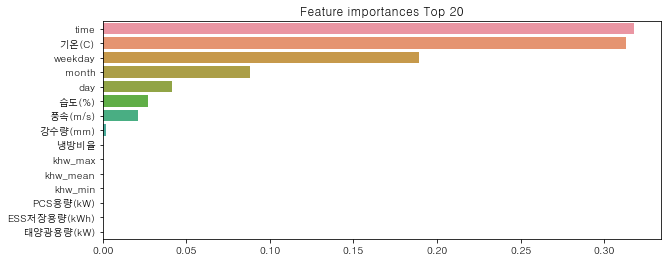

,건물번호,score
0,59.0,0.051203


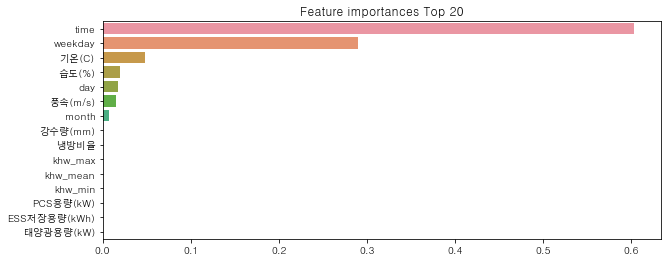

,건물번호,score
0,60.0,0.03813


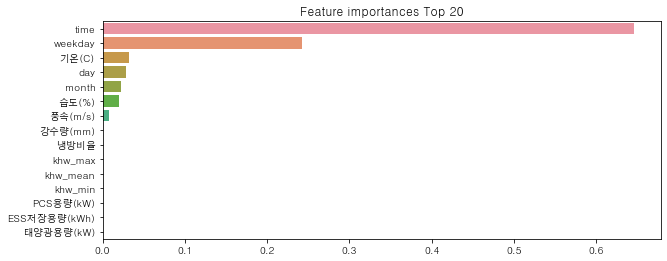

,건물번호,score
0,61.0,0.040432


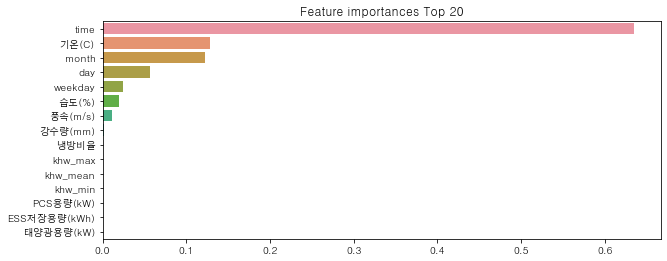

,건물번호,score
0,62.0,0.035786


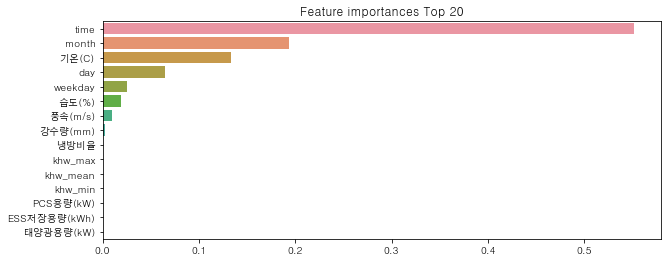

,건물번호,score
0,63.0,0.050126


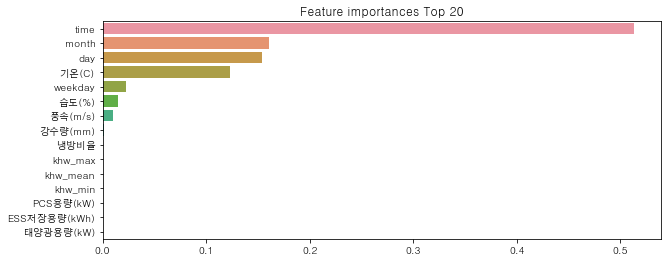

,건물번호,score
0,64.0,0.033311


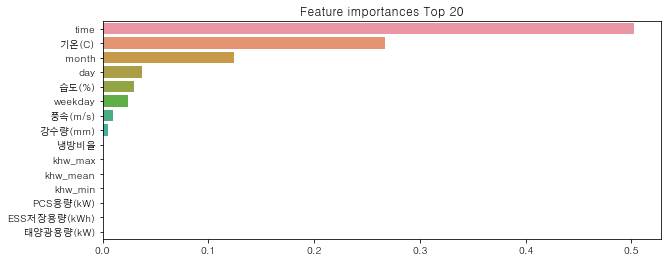

,건물번호,score
0,65.0,0.066671


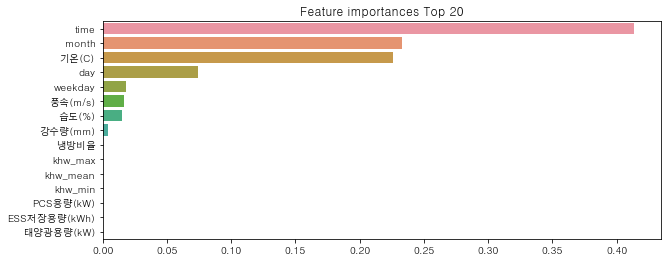

,건물번호,score
0,66.0,0.033039


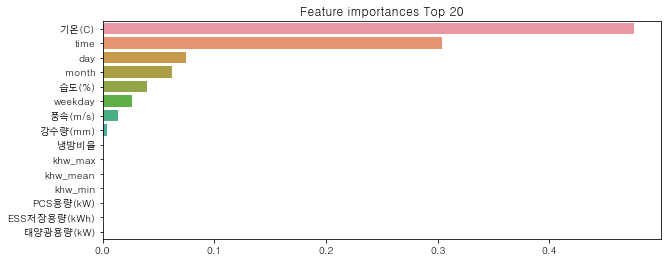

,건물번호,score
0,67.0,0.035071


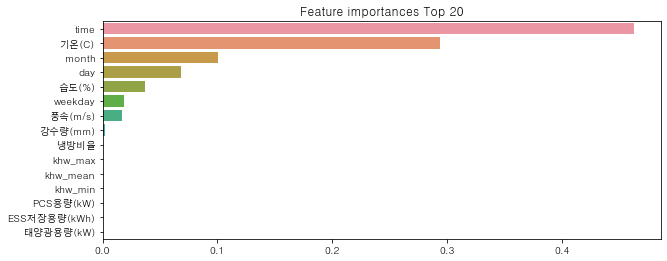

,건물번호,score
0,68.0,0.034963


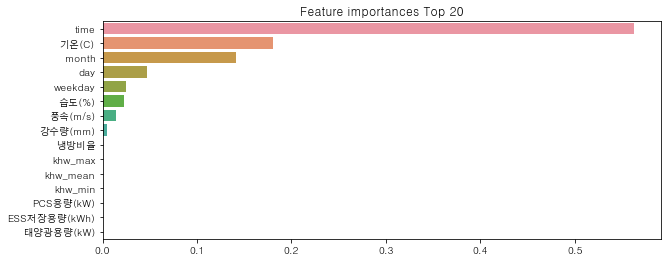

,건물번호,score
0,69.0,0.020227


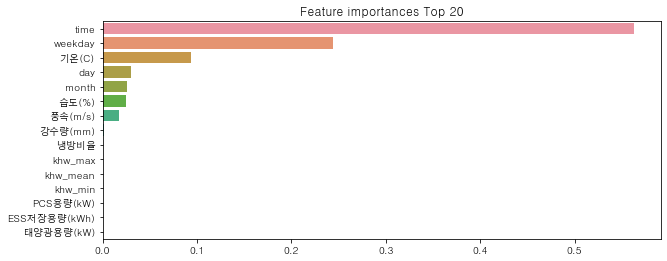

,건물번호,score
0,70.0,0.036134


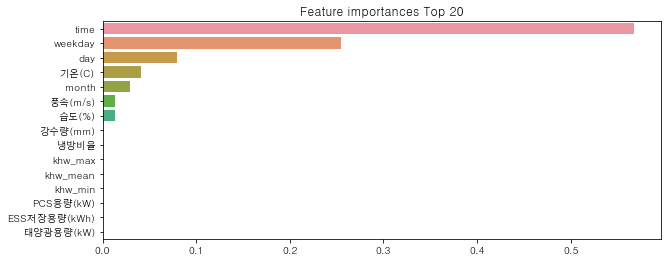

,건물번호,score
0,71.0,0.038652


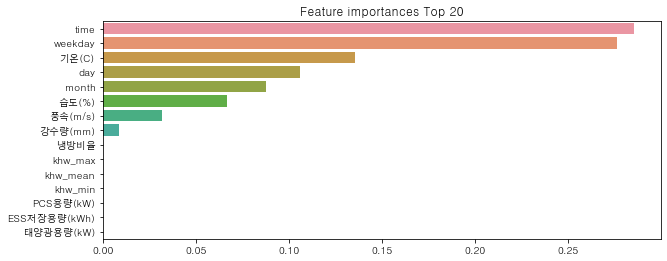

,건물번호,score
0,72.0,0.020629


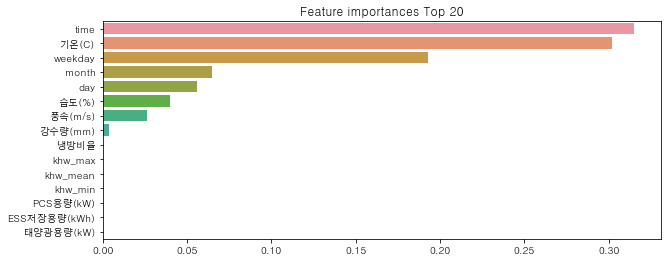

,건물번호,score
0,73.0,0.023943


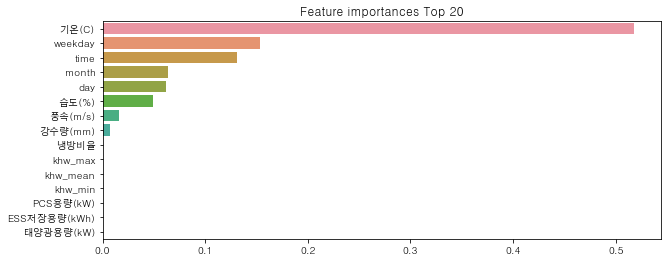

,건물번호,score
0,74.0,0.035253


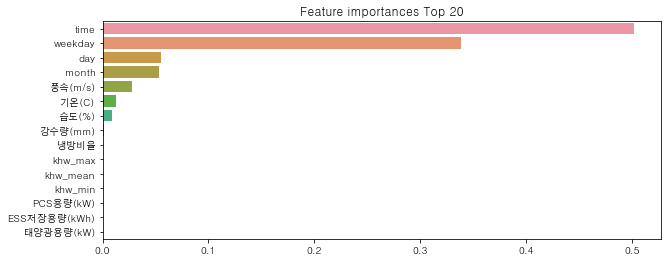

,건물번호,score
0,75.0,0.059314


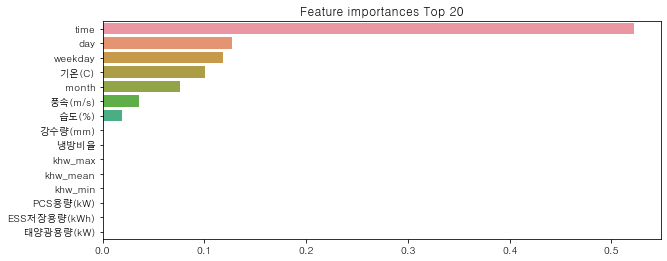

,건물번호,score
0,76.0,0.031983


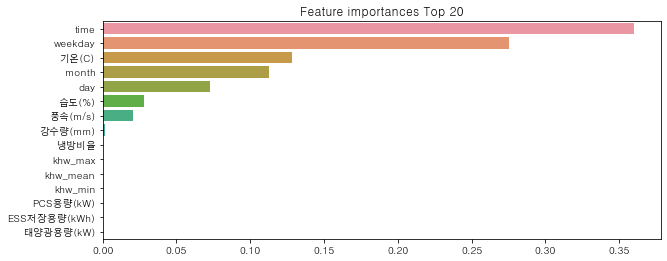

,건물번호,score
0,77.0,0.034288


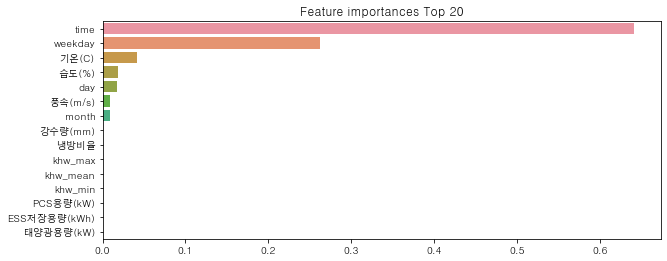

,건물번호,score
0,78.0,0.04372


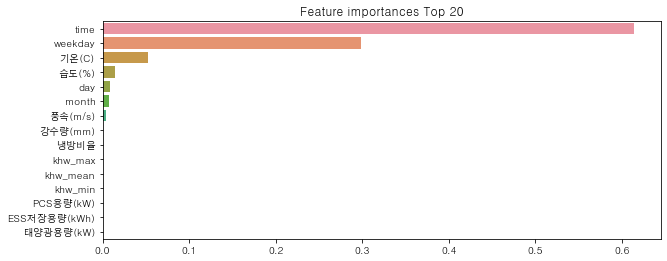

,건물번호,score
0,79.0,0.030941


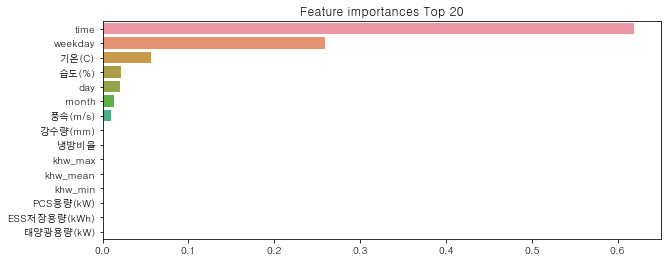

,건물번호,score
0,80.0,0.040192


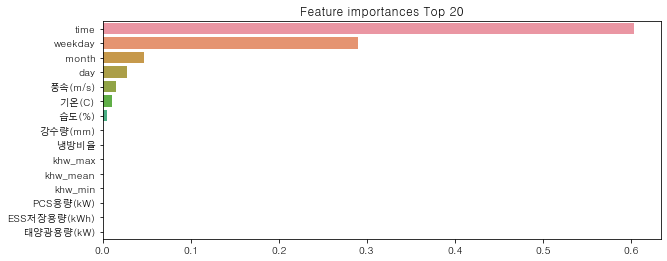

,건물번호,score
0,81.0,0.036031


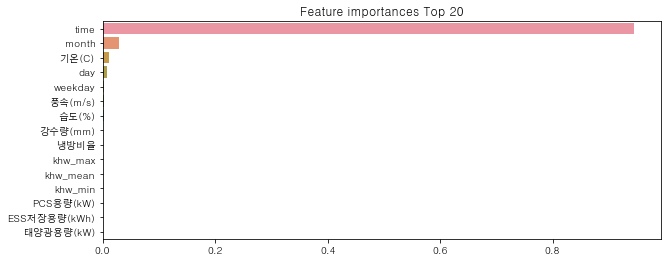

,건물번호,score
0,82.0,0.044367


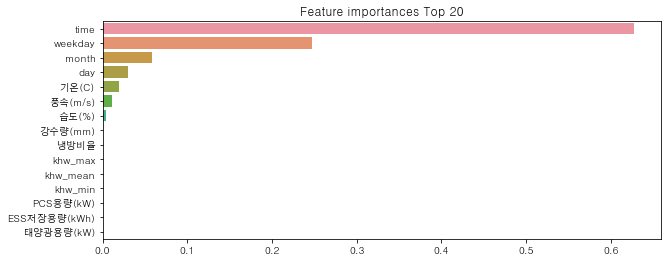

,건물번호,score
0,83.0,0.041344


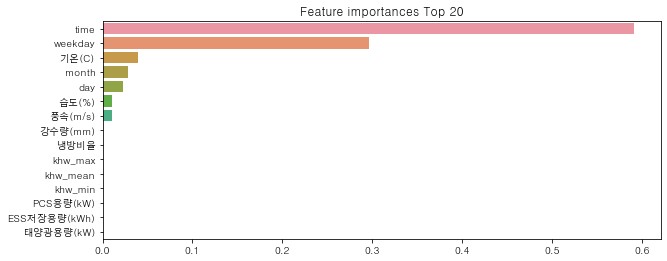

,건물번호,score
0,84.0,0.034556


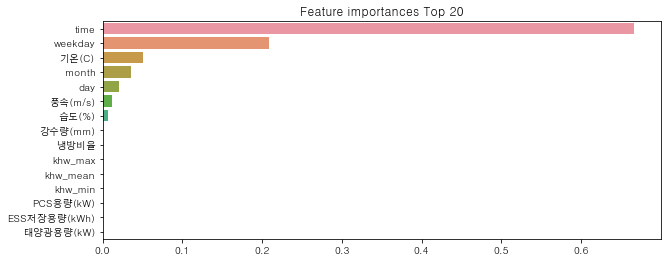

,건물번호,score
0,85.0,0.022337


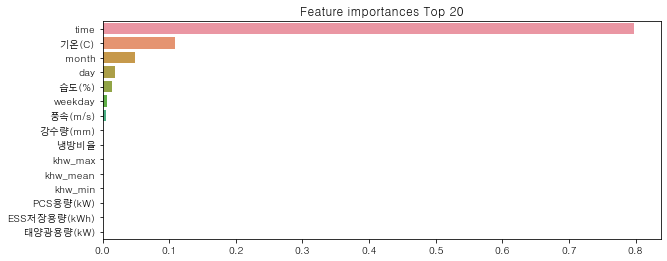

,건물번호,score
0,86.0,0.055472


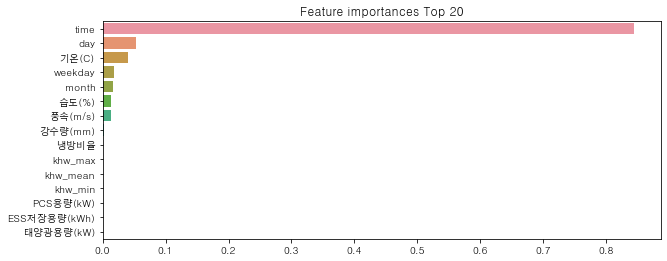

,건물번호,score
0,87.0,0.073968


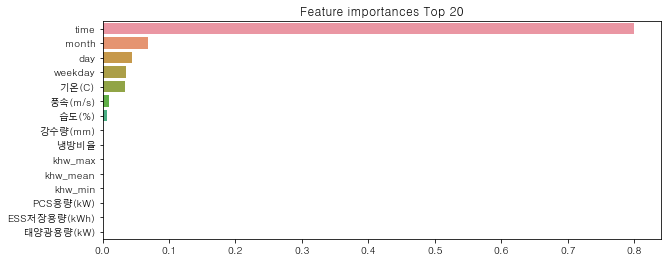

,건물번호,score
0,88.0,0.046313


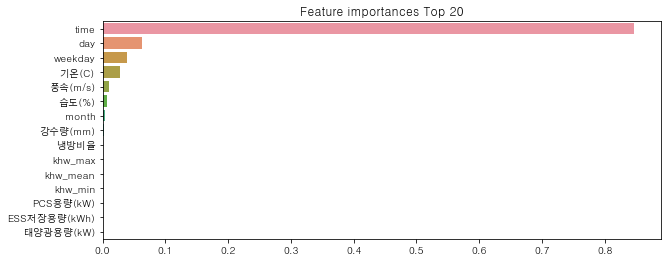

,건물번호,score
0,89.0,0.053966


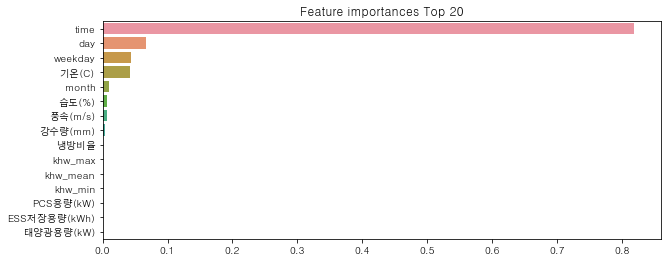

,건물번호,score
0,90.0,0.052409


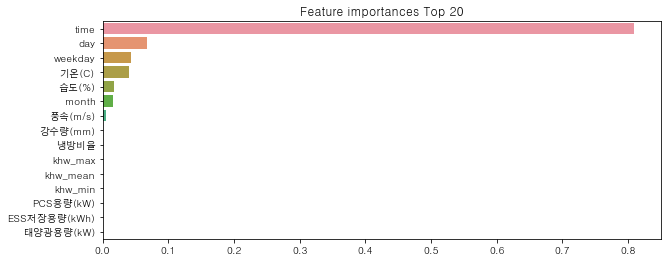

,건물번호,score
0,91.0,0.062982


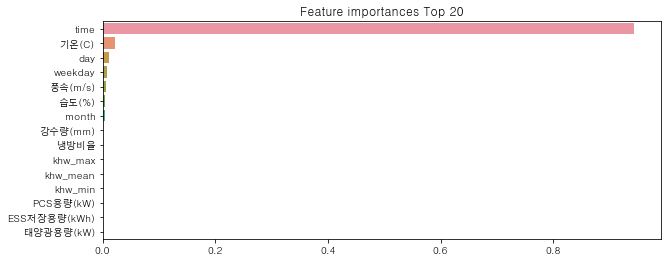

,건물번호,score
0,92.0,0.039602


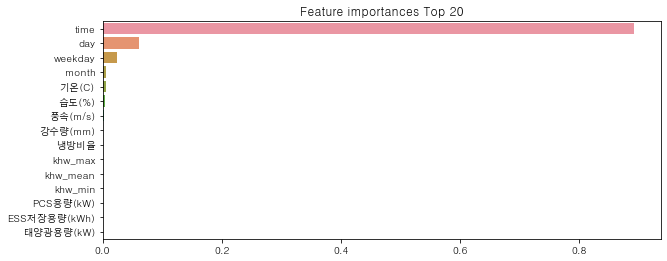

,건물번호,score
0,93.0,0.033266


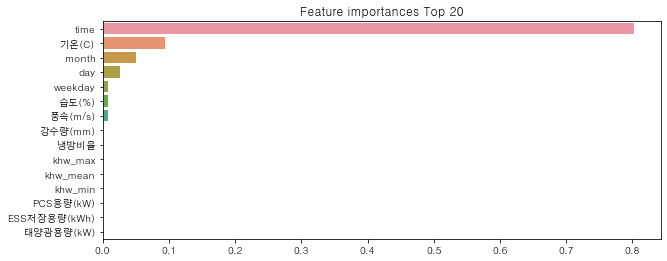

,건물번호,score
0,94.0,0.049012


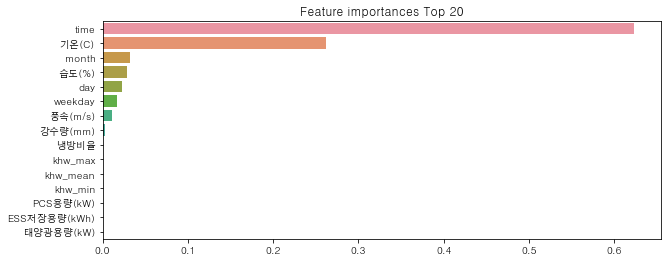

,건물번호,score
0,95.0,0.132225


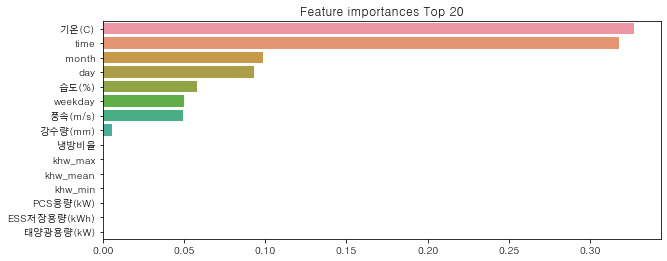

,건물번호,score
0,96.0,0.028703


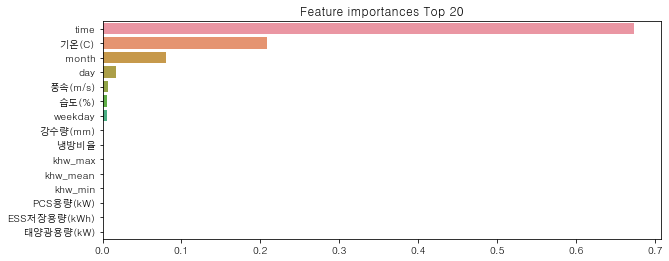

,건물번호,score
0,97.0,0.044819


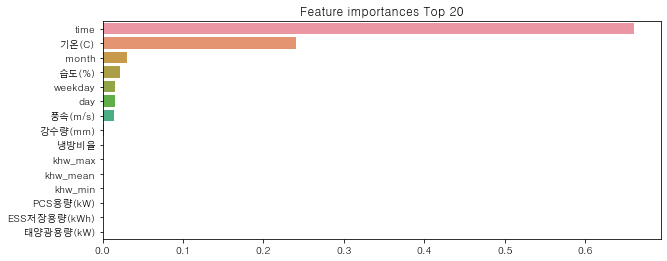

,건물번호,score
0,98.0,0.067754


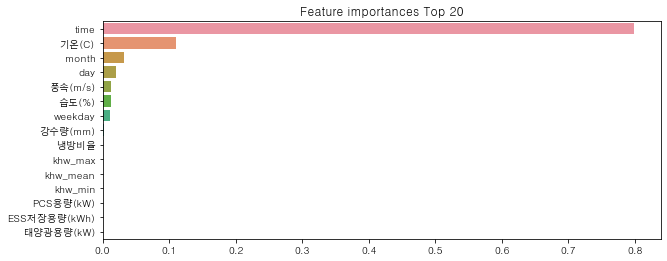

,건물번호,score
0,99.0,0.033192


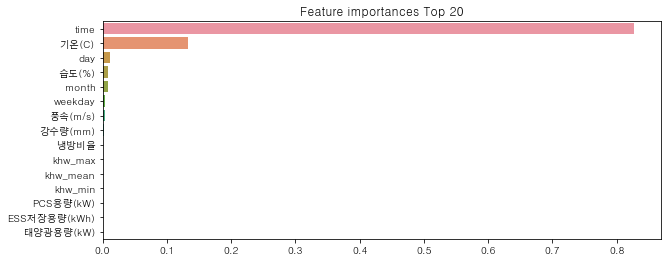

,건물번호,score
0,100.0,0.047923


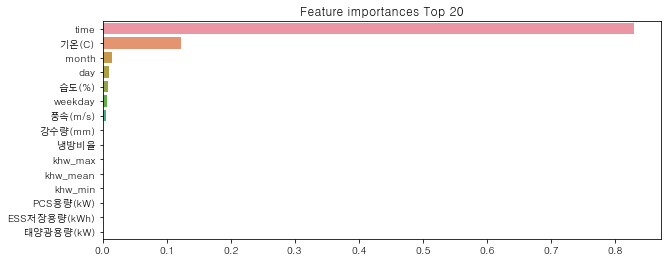


Wall time: 1min 12s


In [22]:
%%time 
metrics = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = X_train[X_train['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_train = y_train.loc[temp_X_train.index]
    
    temp_X_test = X_test[X_test['건물번호'] == i].drop(['건물번호','건물유형'], axis=1)
    temp_y_test = y_test.loc[temp_X_test.index]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
    y_preds = model.predict(temp_X_test)
    
    temp = pd.DataFrame([i, mean_absolute_percentage_error(temp_y_test, y_preds)]).T
    temp.columns = ['건물번호', 'score']
    metrics = metrics.append(temp)
    display(temp)
    vis_feature_importances_(model, temp_X_train)    
    print()

In [23]:
metrics.score.mean()

0.04033043033655735

In [25]:
# metrics.to_excel('건물별.xlsx')

## Inference & Submit

In [26]:
%%time
result = pd.DataFrame()
for i in train['건물번호'].unique():
    
    temp_X_train = train[train['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'], axis=1)
    temp_y_train = train.loc[temp_X_train.index][['전력소비량(kWh)']]
    
    model = RandomForestRegressor(random_state=42)
    model.fit(temp_X_train, temp_y_train)
                                                 
    temp_test = test[test['건물번호'] == i].drop(['건물번호','건물유형','num_date_time', '일시'], axis=1)
    y_preds = model.predict(temp_test)
    result = result.append( pd.concat([test[test['건물번호'] == i].reset_index(), pd.DataFrame(y_preds, columns=['answer']).reset_index()], axis=1) )
    
result.shape    

Wall time: 1min 5s


(16800, 22)

In [28]:
submission.drop('answer', axis=1).merge(result[['num_date_time','answer']], on='num_date_time').to_csv('20230722-2.csv', index=False)